# Recurrent Neural Networks 

For an introduction to RNN take a look at [this great article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). 


## Basic RNNs

In [1]:
# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Tensorflow 
import tensorflow as tf

# 
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### Manual RNN

In [2]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    
print(Y0_val)

[[-0.98634392  0.81788576  0.8470158  -0.99247205  0.68880105]
 [-1.         -0.95546728  0.99203932 -0.99999928 -0.45464534]
 [-1.         -0.99989605  0.99961442 -1.         -0.94950742]
 [-1.         -0.99988145 -0.99999958 -1.         -0.99962741]]


In [3]:
print(Y1_val)

[[-1.         -1.          0.96730083 -1.         -0.99997342]
 [ 0.8294723   0.02448707 -0.94491893 -0.92168093 -0.9122532 ]
 [-1.         -0.99999344 -0.28294998 -0.99999934 -0.99998403]
 [-0.99977511 -0.99972141  0.11019414 -0.98003727 -0.99999589]]


### Using rnn()

The static_rnn() function creates an unrolled RNN network by chaining cells.

In [4]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    
Y0_val

array([[-0.48671275, -0.48561448,  0.86629325, -0.72946197, -0.53452528],
       [-0.99417853, -0.77786744,  0.99997634,  0.10450334,  0.41930473],
       [-0.99995065, -0.91371775,  1.        ,  0.8135196 ,  0.90335333],
       [-0.96949047, -0.57477111,  0.9999451 ,  0.99996626,  0.99443597]], dtype=float32)

In [5]:
Y1_val

array([[-0.99998569, -0.86334312,  1.        ,  0.99911886,  0.99962145],
       [ 0.3538464 ,  0.68475449,  0.39988694,  0.07795403,  0.6127547 ],
       [-0.999672  ,  0.78515959,  0.99999964,  0.99463904,  0.99695826],
       [-0.96491492,  0.90873224,  0.99751562,  0.96221972,  0.96019566]], dtype=float32)

In [6]:
#show_graph(tf.get_default_graph())

### Using dynamic_rnn()

The dynamic_rnn() function uses a while_loop() operation to run over the cell the appropriate number of times, and you can set swap_memory = True if you want it to swap the GPU’s memory to the CPU’s memory during backpropagation to avoid OOM errors. Conveniently, it also accepts a single tensor for all inputs at every time step (shape [None, n_steps, n_inputs]) and it outputs a single tensor for all outputs at every time step (shape [None, n_steps, n_neurons]); there is no need to stack, unstack, or transpose. 

In [7]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    print("outputs =", outputs.eval(feed_dict={X: X_batch}))

outputs = [[[-0.65551144  0.73566824 -0.85184079  0.1408051  -0.67453671]
  [ 0.99524468  0.91472399 -1.          0.99938375  0.91451889]]

 [[-0.37057179  0.9426769  -0.99993008  0.88595641 -0.4519437 ]
  [ 0.61579293  0.03843237  0.7278012   0.42999566  0.21875195]]

 [[ 0.00673045  0.98863083 -1.00000012  0.99033666 -0.15402398]
  [ 0.95808011  0.56590128 -0.99997652  0.9931702   0.9524017 ]]

 [[ 0.92239261 -0.67527854 -0.99997818  0.99998701  0.99996889]
  [ 0.14767335 -0.83654004 -0.99008358  0.92541546  0.95951402]]]


In [8]:
#show_graph(tf.get_default_graph())

### Packing sequences

In [10]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_length = tf.placeholder(tf.int32, [None])   ### <----------------------------------------

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, sequence_length=seq_length, dtype=tf.float32)

init = tf.global_variables_initializer()

X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])


seq_length_batch = np.array([2, 1, 2, 2])  ### <------------------------

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})
    
print(outputs_val)

[[[-0.79451835 -0.44819504 -0.59462738 -0.24471386  0.91153216]
  [-0.9990105   0.97848833 -0.99174058  0.93728083  0.99999642]]

 [[-0.98845619 -0.0552582  -0.95545596  0.09708088  0.99973947]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99941158  0.35557428 -0.9959259   0.4174149   0.99999923]
  [-0.98805785  0.81141108 -0.9052664   0.9342975   0.99974763]]

 [[ 0.77583563  0.58787191 -0.86811101  0.99349481  0.31281272]
  [-0.45480198 -0.14292759 -0.28857675  0.82472932  0.97620714]]]


In [11]:
print(states_val)

[[-0.9990105   0.97848833 -0.99174058  0.93728083  0.99999642]
 [-0.98845619 -0.0552582  -0.95545596  0.09708088  0.99973947]
 [-0.98805785  0.81141108 -0.9052664   0.9342975   0.99974763]
 [-0.45480198 -0.14292759 -0.28857675  0.82472932  0.97620714]]


### Training a sequence classifier

We will treat each image as a sequence of 28 rows of 28 pixels each (since each MNIST image is 28 × 28 pixels). We will use cells of 150 recurrent neurons, plus a fully connected layer containing 10 neurons (one per class) connected to the output of the last time step, followed by a softmax layer. 

In [12]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.variable_scope("rnn", initializer=tf.contrib.layers.variance_scaling_initializer()):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = fully_connected(states, n_outputs, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train accuracy: 0.92 Test accuracy: 0.9297
1 Train accuracy: 0.953333 Test accuracy: 0.9524
2 Train accuracy: 0.96 Test accuracy: 0.9613
3 Train accuracy: 0.98 Test accuracy: 0.9688
4 Train accuracy: 0.946667 Test accuracy: 0.9607
5 Train accuracy: 0.96 Test accuracy: 0.9676
6 Train accuracy: 0.98 Test accuracy: 0.9729
7 Train accuracy: 0.973333 Test accuracy: 0.9747
8 Train accuracy: 0.973333 Test accuracy: 0.9711
9 Train accuracy: 0.966667 Test accuracy: 0.9746
10 Train accuracy: 0.986667 Test accuracy: 0.974
11 Train accuracy: 0.993333 Test a

### Training the same sequence classifier with Keras 

In [30]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN
from keras import initializers
from keras.optimizers import RMSprop

from keras.models import Model
from keras.layers import Input, Dense

batch_size = 150
num_classes = 10
epochs = 100
hidden_units = 150

learning_rate = 0.001

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28)
x_test = x_test.reshape(x_test.shape[0], 28, 28)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('Evaluate IRNN...')
a = Input(shape=x_train.shape[1:])
b = SimpleRNN(hidden_units,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(),
                    activation='relu')(a)
b = Dense(num_classes)(b)
b = Activation('softmax')(b)
optimizer = keras.optimizers.Adamax(lr=learning_rate)
model = Model(inputs=[a], outputs=[b])
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

scores = model.evaluate(x_test, y_test, verbose=0)
print('IRNN test score:', scores[0])
print('IRNN test accuracy:', scores[1])

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
Evaluate IRNN...
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 21s - loss: 0.7979 - acc: 0.7312 - val_loss: 0.3889 - val_acc: 0.8750
Epoch 2/100
60000/60000 [==============================] - 21s - loss: 0.3082 - acc: 0.9014 - val_loss: 0.2438 - val_acc: 0.9230
Epoch 3/100
60000/60000 [==============================] - 20s - loss: 0.2165 - acc: 0.9318 - val_loss: 0.2059 - val_acc: 0.9335
Epoch 4/100
60000/60000 [==============================] - 22s - loss: 0.1745 - acc: 0.9449 - val_loss: 0.1507 - val_acc: 0.9531
Epoch 5/100
60000/60000 [==============================] - 20s - loss: 0.1429 - acc: 0.9544 - val_loss: 0.1242 - val_acc: 0.9608
Epoch 6/100
60000/60000 [==============================] - 20s - loss: 0.1263 - acc: 0.9608 - val_loss: 0.1186 - val_acc: 0.9642
Epoch 7/100
60000/60000 [==============================] - 21s - loss: 0.1089 - acc: 0.96

60000/60000 [==============================] - 21s - loss: 0.0077 - acc: 0.9975 - val_loss: 0.0728 - val_acc: 0.9841
Epoch 63/100
60000/60000 [==============================] - 20s - loss: 0.0062 - acc: 0.9980 - val_loss: 0.0724 - val_acc: 0.9831
Epoch 64/100
60000/60000 [==============================] - 20s - loss: 0.0059 - acc: 0.9980 - val_loss: 0.0812 - val_acc: 0.9839
Epoch 65/100
60000/60000 [==============================] - 21s - loss: 0.0070 - acc: 0.9977 - val_loss: 0.0799 - val_acc: 0.9837
Epoch 66/100
60000/60000 [==============================] - 20s - loss: 0.0064 - acc: 0.9979 - val_loss: 0.1002 - val_acc: 0.9821
Epoch 67/100
60000/60000 [==============================] - 21s - loss: 0.0072 - acc: 0.9977 - val_loss: 0.0790 - val_acc: 0.9841.0073 
Epoch 68/100
60000/60000 [==============================] - 22s - loss: 0.0069 - acc: 0.9976 - val_loss: 0.0788 - val_acc: 0.9839
Epoch 69/100
60000/60000 [==============================] - 21s - loss: 0.0061 - acc: 0.9982 - va

## Multi-layer RNN

It is quite common to stack multiple layers of cells. This gives you a __deep RNN__.
To implement a deep RNN in TensorFlow, you can create several cells and stack them into a __MultiRNNCell__.

In [32]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons1 = 150
n_neurons2 = 100
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

hidden1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons1, activation=tf.nn.relu)
hidden2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons2, activation=tf.nn.relu)
multi_layer_cell = tf.contrib.rnn.MultiRNNCell([hidden1, hidden2])
outputs, states_tuple = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
states = tf.concat(axis=1, values=states_tuple)
logits = fully_connected(states, n_outputs, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
0 Train accuracy: 0.926667 Test accuracy: 0.9232
1 Train accuracy: 0.973333 Test accuracy: 0.9529
2 Train accuracy: 0.966667 Test accuracy: 0.9612
3 Train accuracy: 0.98 Test accuracy: 0.9734
4 Train accuracy: 0.973333 Test accuracy: 0.968
5 Train accuracy: 0.973333 Test accuracy: 0.9664
6 Train accuracy: 0.98 Test accuracy: 0.9789
7 Train accuracy: 0.98 Test accuracy: 0.9729
8 Train accuracy: 0.993333 Test accuracy: 0.9771
9 Train accuracy: 0.96 Test accuracy: 0.9758
10 Train accuracy: 0.993333 Test accuracy: 0.9778
11 Train accuracy: 0.96 Test accuracy: 0.9824
12 Train accuracy: 1.0 Test accuracy: 0.9782
13 Train accuracy: 0.966667 Test accuracy: 0.9815
14 Train accuracy: 0.98 Test accuracy: 0.9819
15 Train accuracy: 1.0 Test accuracy: 0.984
16 Train accuracy: 0.986667 Test accuracy: 0.9763
17 Tra

## Multi-layer RNN with Keras 

When stacking RNNs with Keras remember to set __return_sequences=True__ on hidden layers.  

In [39]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN
from keras import initializers
from keras.optimizers import RMSprop

from keras.models import Model
from keras.layers import Input, Dense

keras.backend.clear_session()

batch_size = 150
num_classes = 10
epochs = 50 # instead of 100 (too much time)
hidden_units_1 = 150
hidden_units_2 = 100

learning_rate = 0.001

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28)
x_test = x_test.reshape(x_test.shape[0], 28, 28)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('Evaluate IRNN...')
a = Input(shape=x_train.shape[1:])
b = SimpleRNN(hidden_units_1,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(),
                    activation='relu' , return_sequences=True)(a)
b = SimpleRNN(hidden_units_2,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(),
                    activation='relu')(b)
b = Dense(num_classes)(b)
b = Activation('softmax')(b)
optimizer = keras.optimizers.Adamax(lr=learning_rate)
model = Model(inputs=[a], outputs=[b])
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

scores = model.evaluate(x_test, y_test, verbose=0)
print('IRNN test score:', scores[0])
print('IRNN test accuracy:', scores[1])

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
Evaluate IRNN...
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 44s - loss: 0.7986 - acc: 0.7263 - val_loss: 0.3711 - val_acc: 0.8834
Epoch 2/50
60000/60000 [==============================] - 46s - loss: 0.2963 - acc: 0.9078 - val_loss: 0.2352 - val_acc: 0.9262
Epoch 3/50
60000/60000 [==============================] - 44s - loss: 0.1983 - acc: 0.9386 - val_loss: 0.2365 - val_acc: 0.9241
Epoch 4/50
60000/60000 [==============================] - 43s - loss: 0.1630 - acc: 0.9498 - val_loss: 0.1340 - val_acc: 0.9574
Epoch 5/50
60000/60000 [==============================] - 43s - loss: 0.1308 - acc: 0.9598 - val_loss: 0.1228 - val_acc: 0.9629
Epoch 6/50
60000/60000 [==============================] - 43s - loss: 0.1177 - acc: 0.9638 - val_loss: 0.0982 - val_acc: 0.9703
Epoch 7/50
60000/60000 [==============================] - 44s - loss: 0.1038 - acc: 0.9684 - va

## Time series

Now let’s take a look at how to handle time series, such as stock prices, air temperature, brain wave patterns, and so on. In this section we will train an RNN to predict the next value in a generated time series. Each training instance is a randomly selected sequence of 20 consecutive values from the time series, and the target sequence is the same as the input sequence, except it is shifted by one time step into the future. 

C:\Users\gtesei\AppData\Local\Continuum\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


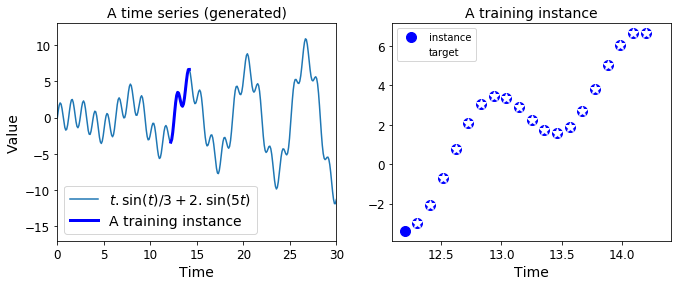

In [51]:
t_min, t_max = 0, 30

n_steps = 20

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps,resolution = 0.1):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

t = np.linspace(t_min, t_max, (t_max - t_min) // resolution)
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

In [52]:
X_batch, y_batch = next_batch(1, n_steps)
np.c_[X_batch[0], y_batch[0]]

array([[-3.0913747 , -1.81370459],
       [-1.81370459, -0.2545896 ],
       [-0.2545896 ,  1.35043982],
       [ 1.35043982,  2.75633863],
       [ 2.75633863,  3.76705941],
       [ 3.76705941,  4.28205029],
       [ 4.28205029,  4.31936936],
       [ 4.31936936,  4.00977195],
       [ 4.00977195,  3.56323364],
       [ 3.56323364,  3.2161207 ],
       [ 3.2161207 ,  3.17195748],
       [ 3.17195748,  3.55030744],
       [ 3.55030744,  4.35629752],
       [ 4.35629752,  5.47826041],
       [ 5.47826041,  6.71408441],
       [ 6.71408441,  7.81983055],
       [ 7.81983055,  8.56872404],
       [ 8.56872404,  8.80608565],
       [ 8.80608565,  8.48676122],
       [ 8.48676122,  7.68589142]])

### Using an OuputProjectionWrapper

In [53]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 20171.0
100 	MSE: 858.855
200 	MSE: 422.972
300 	MSE: 199.725
400 	MSE: 90.7315
500 	MSE: 56.7009
600 	MSE: 53.6289
700 	MSE: 62.3246
800 	MSE: 50.8053
900 	MSE: 53.6313
[[[-3.49738097]
  [-2.51607442]
  [-1.16632104]
  [ 0.60030717]
  [ 2.15503573]
  [ 3.01053429]
  [ 3.41778255]
  [ 3.32022381]
  [ 2.88544369]
  [ 2.23823047]
  [ 1.69417715]
  [ 1.57740271]
  [ 1.955423  ]
  [ 2.77756476]
  [ 3.91065073]
  [ 5.11356974]
  [ 6.10596704]
  [ 6.64041662]
  [ 6.67867994]
  [ 6.1244235 ]]]


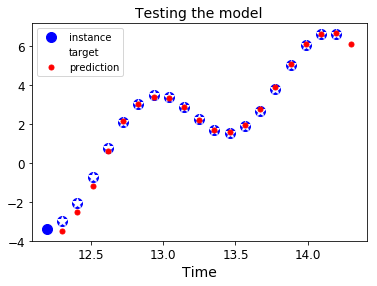

In [55]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

### Without using an OutputProjectionWrapper

In [89]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = fully_connected(stacked_rnn_outputs, n_outputs, activation_fn=None)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 16.1839
100 	MSE: 0.396811
200 	MSE: 0.124991
300 	MSE: 0.0574633
400 	MSE: 0.0538617
500 	MSE: 0.059357
600 	MSE: 0.047703
700 	MSE: 0.0494709
800 	MSE: 0.0483082
900 	MSE: 0.0500153
[[[-3.46322608]
  [-2.48452091]
  [-1.10020792]
  [ 0.58717555]
  [ 2.00378942]
  [ 3.0813272 ]
  [ 3.52336788]
  [ 3.42467713]
  [ 2.84561419]
  [ 2.11835122]
  [ 1.66789067]
  [ 1.52136159]
  [ 1.86960983]
  [ 2.6718235 ]
  [ 3.84957361]
  [ 5.06223202]
  [ 6.07499313]
  [ 6.60482883]
  [ 6.601717  ]
  [ 5.99486113]]]


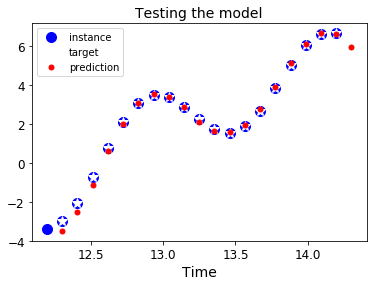

In [57]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

### With Keras 

In [95]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN
from keras import initializers
from keras.optimizers import RMSprop

from keras.models import Model
from keras.layers import Input, Dense

def ts_next_batch(batch_size, n_steps,resolution = 0.1):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

keras.backend.clear_session()

batch_size = 50
hidden_units = 100
learning_rate = 0.001
n_inputs = 1
n_outputs = 1
n_steps = 20

print('Evaluate IRNN...')
a = Input(shape=(n_steps,n_inputs))
b = SimpleRNN(hidden_units,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(),
                    activation='relu' ,  return_sequences=True)(a)
b = keras.layers.core.Reshape((-1,n_neurons))(b)
b = Dense(1,activation=None)(b)
b = keras.layers.core.Reshape((n_steps, n_outputs))(b)
optimizer = keras.optimizers.Adamax(lr=learning_rate)
model = Model(inputs=[a], outputs=[b])
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_squared_error'])

X_batch, y_batch = ts_next_batch(batch_size*1000, n_steps)
x_test, y_test = ts_next_batch(batch_size, n_steps)
model.fit(X_batch, y_batch,
          batch_size=batch_size,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

Evaluate IRNN...
Train on 50000 samples, validate on 50 samples
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 1.8889 - mean_squared_error: 1.8889 - val_loss: 0.4352 - val_mean_squared_error: 0.4352


In [96]:
X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
y_pred = model.predict(X_new,verbose=0)
print(y_pred)

[[[-1.70384717]
  [-3.05007172]
  [-2.39496326]
  [-0.14787099]
  [ 1.67567396]
  [ 2.97915959]
  [ 3.60192847]
  [ 3.50552845]
  [ 2.90764904]
  [ 2.10811305]
  [ 1.44303656]
  [ 1.22440231]
  [ 1.58337164]
  [ 2.46381497]
  [ 3.68792629]
  [ 4.98927641]
  [ 6.08448458]
  [ 6.71567392]
  [ 6.7268734 ]
  [ 6.1052804 ]]]


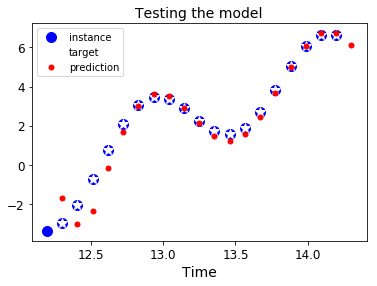

In [97]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

### Dropout

If you build a very deep RNN, it may end up overfitting the training set. To prevent that, a common technique is to apply dropout. You can simply add a dropout layer before or after the RNN as usual, but if you also want to apply dropout between the RNN layers, you need to use a DropoutWrapper.

In [104]:
tf.reset_default_graph()
from tensorflow.contrib.layers import fully_connected

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

keep_prob = 0.5
learning_rate = 0.001

is_training = True

def deep_rnn_with_dropout(X, y, is_training):
    if is_training:
        multi_layer_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons), input_keep_prob=keep_prob) for _ in range(n_layers)],)
    else: 
        multi_layer_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons) for _ in range(n_layers)],)
        
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = fully_connected(stacked_rnn_outputs, n_outputs, activation_fn=None)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

    loss = tf.reduce_mean(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    return outputs, loss, training_op

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
outputs, loss, training_op = deep_rnn_with_dropout(X, y, is_training)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_iterations = 2000
batch_size = 50

with tf.Session() as sess:
    if is_training:
        init.run()
        for iteration in range(n_iterations):
            X_batch, y_batch = next_batch(batch_size, n_steps)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 100 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                print(iteration, "\tMSE:", mse)
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
        plt.title("Testing the model", fontsize=14)
        plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
        plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
        plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.show()

0 	MSE: 13.1851
100 	MSE: 5.1124
200 	MSE: 3.35787
300 	MSE: 3.95527
400 	MSE: 3.24614
500 	MSE: 4.12
600 	MSE: 3.30315
700 	MSE: 2.72216
800 	MSE: 2.72711
900 	MSE: 3.54013
1000 	MSE: 2.55609
1100 	MSE: 2.66153
1200 	MSE: 2.37055
1300 	MSE: 2.55441
1400 	MSE: 2.08881
1500 	MSE: 1.91476
1600 	MSE: 3.05383
1700 	MSE: 2.6395
1800 	MSE: 2.75546
1900 	MSE: 2.03541


INFO:tensorflow:Restoring parameters from /tmp/my_model.ckpt


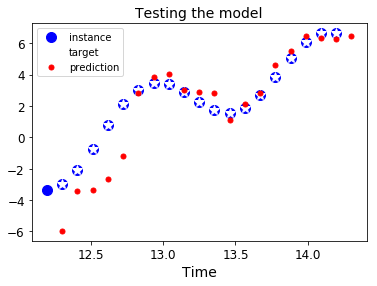

In [105]:
is_training = False
with tf.Session() as sess:
    if is_training:
        init.run()
        for iteration in range(n_iterations):
            X_batch, y_batch = next_batch(batch_size, n_steps)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 100 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                print(iteration, "\tMSE:", mse)
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
        plt.title("Testing the model", fontsize=14)
        plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
        plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
        plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.show()

### Dropout with Keras 

In [108]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import SimpleRNN
from keras import initializers
from keras.optimizers import RMSprop

from keras.models import Model
from keras.layers import Input, Dense

def ts_next_batch(batch_size, n_steps,resolution = 0.1):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

keras.backend.clear_session()

batch_size = 50
hidden_units = 100
learning_rate = 0.001
n_inputs = 1
n_outputs = 1
n_steps = 20

n_layers = 3
keep_prob = 0.5

print('Evaluate IRNN...')
a = Input(shape=(n_steps,n_inputs))
b = SimpleRNN(hidden_units,
                        kernel_initializer=initializers.RandomNormal(stddev=0.001),
                        recurrent_initializer=initializers.Identity(),
                        activation='relu' ,  return_sequences=True)(a)
b = Dropout(keep_prob)(b)
for i in range(n_layers-1): 
    b = SimpleRNN(hidden_units,
                        kernel_initializer=initializers.RandomNormal(stddev=0.001),
                        recurrent_initializer=initializers.Identity(),
                        activation='relu' ,  return_sequences=True)(a)
    b = Dropout(keep_prob)(b)
b = keras.layers.core.Reshape((-1,n_neurons))(b)
b = Dense(1,activation=None)(b)
b = keras.layers.core.Reshape((n_steps, n_outputs))(b)
optimizer = keras.optimizers.Adamax(lr=learning_rate)
model = Model(inputs=[a], outputs=[b])
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_squared_error'])

X_batch, y_batch = ts_next_batch(batch_size*2000, n_steps)
x_test, y_test = ts_next_batch(batch_size*2, n_steps)
model.fit(X_batch, y_batch,
          batch_size=batch_size,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

Evaluate IRNN...
Train on 100000 samples, validate on 100 samples
Epoch 1/1
100000/100000 [==============================] - 34s - loss: 1.3340 - mean_squared_error: 1.3340 - val_loss: 0.1600 - val_mean_squared_error: 0.1600


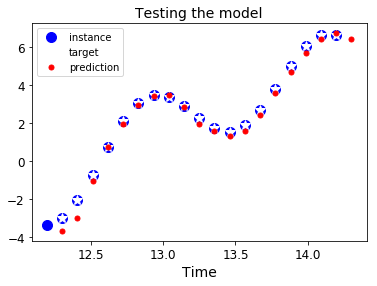

In [110]:
X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
y_pred = model.predict(X_new,verbose=0)
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

### LSTM

The Long Short-Term Memory (LSTM) cell was proposed in (Hochreiter-Schmidhuber,1997), and it was gradually improved over the years by several researchers. If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster and it will detect long-term dependencies in the data.

In [113]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

n_layers = 3 

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

multi_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons) for _ in range(n_layers)])
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = fully_connected(top_layer_h_state, n_outputs, activation_fn=None, scope="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch 0 Train accuracy = 0.966667 Test accuracy = 0.9582
Epoch 1 Train accuracy = 0.966667 Test accuracy = 0.9684
Epoch 2 Train accuracy = 0.986667 Test accuracy = 0.973
Epoch 3 Train accuracy = 0.986667 Test accuracy = 0.9803
Epoch 4 Train accuracy = 0.993333 Test accuracy = 0.9848
Epoch 5 Train accuracy = 0.973333 Test accuracy = 0.986
Epoch 6 Train accuracy = 1.0 Test accuracy = 0.9867
Epoch 7 Train accuracy = 0.993333 Test accuracy = 0.9862
Epoch 8 Train accuracy = 1.0 Test accuracy = 0.9878
Epoch 9 Train accuracy = 0.993333 Test accuracy = 0.9878


### LSTM with Keras 

In [124]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras import initializers
from keras.optimizers import RMSprop


from keras.models import Model
from keras.layers import Input, Dense

keras.backend.clear_session()

batch_size = 150
num_classes = 10
epochs = 10 
n_neurons = 150
n_layers = 3 
learning_rate = 0.001

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28)
x_test = x_test.reshape(x_test.shape[0], 28, 28)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('Evaluate LSTM...')
a = Input(shape=x_train.shape[1:])

b = LSTM(n_neurons,return_sequences=True)(a)
for i in range(n_layers-2):
    b = LSTM(n_neurons,return_sequences=True)(b)

b = LSTM(n_neurons,return_sequences=False)(b)

b = Dense(num_classes)(b)
b = Activation('softmax')(b)

optimizer = keras.optimizers.Adamax(lr=learning_rate)
model = Model(inputs=[a], outputs=[b])

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

scores = model.evaluate(x_test, y_test, verbose=0)
print('LSTM test score:', scores[0])
print('LSTM test accuracy:', scores[1])

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
Evaluate LSTM...
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 374s - loss: 0.6565 - acc: 0.7826 - val_loss: 0.2588 - val_acc: 0.9194
Epoch 2/10
60000/60000 [==============================] - 370s - loss: 0.1966 - acc: 0.9386 - val_loss: 0.1571 - val_acc: 0.9512
Epoch 3/10
60000/60000 [==============================] - 369s - loss: 0.1331 - acc: 0.9588 - val_loss: 0.1104 - val_acc: 0.9652
Epoch 4/10
60000/60000 [==============================] - 371s - loss: 0.1061 - acc: 0.9675 - val_loss: 0.0876 - val_acc: 0.9709
Epoch 5/10
60000/60000 [==============================] - 375s - loss: 0.0831 - acc: 0.9739 - val_loss: 0.0838 - val_acc: 0.9749
Epoch 6/10
60000/60000 [==============================] - 356s - loss: 0.0696 - acc: 0.9782 - val_loss: 0.0747 - val_acc: 0.9769
Epoch 7/10
60000/60000 [==============================] - 379s - loss: 0.0587 - acc: 0.98

### Distributing layers across devices

If you try to create each cell in a different device() block, it will not work.

In [128]:
with tf.device("/gpu:0"): # BAD! This is ignored. 
    layer1 = tf.contrib.rnn.BasicRNNCell( num_units = n_neurons) 
    
with tf.device("/gpu:1"): # BAD! Ignored again. 
    layer2 = tf.contrib.rnn.BasicRNNCell( num_units = n_neurons)

This fails because a BasicRNNCell is a cell factory, not a cell per se; no cells get created when you create the factory, and thus no variables do either. The device block is simply ignored. The cells actually get created later. When you call dynamic_rnn(), it calls the MultiRNNCell, which calls each individual BasicRNNCell, which create the actual cells (including their variables). Unfortunately, none of these classes provide any way to control the devices on which the variables get created. If you try to put the dynamic_rnn() call within a device block, the whole RNN gets pinned to a single device. 

__The trick is to create your own cell wrapper__

In [129]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)
    
tf.reset_default_graph()

n_inputs = 5
n_neurons = 100
devices = ["/cpu:0"]*5
n_steps = 20
X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
lstm_cells = [DeviceCellWrapper(device, tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
              for device in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: rnd.rand(2, n_steps, n_inputs)}))

[[[ 0.01774996 -0.00240297 -0.06099286 ...,  0.01896067  0.0262568
   -0.10385772]
  [-0.01140774  0.07944129  0.09548181 ...,  0.17136577  0.07142816
    0.02270918]
  [ 0.01077356 -0.19770344  0.03775163 ...,  0.16440447 -0.03113544
   -0.15833262]
  ..., 
  [ 0.18550645 -0.045463   -0.54991585 ...,  0.06169901 -0.02102067
   -0.13856457]
  [ 0.00486014  0.19622976  0.08843058 ...,  0.06885004  0.170504
   -0.2080622 ]
  [ 0.07338118 -0.52152467 -0.42612541 ...,  0.47807157 -0.01505137
   -0.56541729]]

 [[ 0.0101305  -0.04053771 -0.00590748 ...,  0.01823444  0.04402071
   -0.0789765 ]
  [ 0.04542742  0.03866118  0.08369439 ...,  0.09143315  0.0773553
    0.03683787]
  [ 0.15722416 -0.07377757  0.06061554 ...,  0.22006992  0.00631647
   -0.26226565]
  ..., 
  [-0.39800081  0.3084473  -0.19721624 ...,  0.2082005  -0.04525452
   -0.24870294]
  [-0.50827909  0.06136992 -0.232437   ...,  0.33199015 -0.07412967
   -0.4881908 ]
  [-0.28511611  0.12590477 -0.36025527 ...,  0.5273127   0.080

 # Bidirectional LSTM on the IMDB sentiment classification task on Keras 

In [138]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

del model
keras.backend.clear_session()

max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 277s - loss: 0.4149 - acc: 0.8074 - val_loss: 0.3521 - val_acc: 0.8450
Epoch 2/4
25000/25000 [==============================] - 249s - loss: 0.2238 - acc: 0.9139 - val_loss: 0.3632 - val_acc: 0.8469
Epoch 3/4
25000/25000 [==============================] - 262s - loss: 0.1290 - acc: 0.9532 - val_loss: 0.4287 - val_acc: 0.8361
Epoch 4/4
25000/25000 [==============================] - 279s - loss: 0.0697 - acc: 0.9765 - val_loss: 0.6076 - val_acc: 0.8346


## LSTM on the IMDB sentiment classification task on Keras

In [162]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

del model
keras.backend.clear_session()

max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 182s - loss: 0.4149 - acc: 0.8062 - val_loss: 0.3396 - val_acc: 0.8514
Epoch 2/4
25000/25000 [==============================] - 169s - loss: 0.2322 - acc: 0.9110 - val_loss: 0.4239 - val_acc: 0.8191
Epoch 3/4
25000/25000 [==============================] - 171s - loss: 0.1457 - acc: 0.9482 - val_loss: 0.4668 - val_acc: 0.8398
Epoch 4/4
25000/25000 [==============================] - 168s - loss: 0.1000 - acc: 0.9656 - val_loss: 0.5299 - val_acc: 0.8356


## LSTM+FC on the IMDB sentiment classification task on Keras

In [161]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

del model
keras.backend.clear_session()

max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 163s - loss: 0.4247 - acc: 0.8021 - val_loss: 0.3404 - val_acc: 0.8504
Epoch 2/4
25000/25000 [==============================] - 157s - loss: 0.2330 - acc: 0.9117 - val_loss: 0.4124 - val_acc: 0.8258
Epoch 3/4
25000/25000 [==============================] - 156s - loss: 0.1394 - acc: 0.9501 - val_loss: 0.4462 - val_acc: 0.8374
Epoch 4/4
25000/25000 [==============================] - 156s - loss: 0.0926 - acc: 0.9672 - val_loss: 0.5852 - val_acc: 0.8339


## Recurrent convolutional network on the IMDB sentiment

In [159]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb

del model
keras.backend.clear_session()

# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 4

'''
Note:
batch_size is highly sensitive.
Only 2 epochs are needed as the dataset is very small.
'''

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 116s - loss: 0.3830 - acc: 0.8228 - val_loss: 0.3617 - val_acc: 0.8458
Epoch 2/4
25000/25000 [==============================] - 121s - loss: 0.1969 - acc: 0.9251 - val_loss: 0.3810 - val_acc: 0.8485
Epoch 3/4
25000/25000 [==============================] - 110s - loss: 0.0965 - acc: 0.9669 - val_loss: 0.4206 - val_acc: 0.8420
Epoch 4/4
24990/25000 [============================>.] - ETA: 0sTest score: 0.557802463364
Test accuracy: 0.839679995275


## Convolutional network on the IMDB sentiment

In [158]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

keras.backend.clear_session()
del model

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 4

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
Build model...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 307s - loss: 0.4115 - acc: 0.7988 - val_loss: 0.2973 - val_acc: 0.8733
Epoch 2/4
25000/25000 [==============================] - 312s - loss: 0.2450 - acc: 0.9002 - val_loss: 0.2842 - val_acc: 0.8824
Epoch 3/4
25000/25000 [==============================] - 314s - loss: 0.1767 - acc: 0.9320 - val_loss: 0.2847 - val_acc: 0.8828
Epoch 4/4
25000/25000 [==============================] - 342s - loss: 0.1240 - acc: 0.9539 - val_loss: 0.3543 - val_acc: 0.8720


## IMDB datasets with bi-gram embeddings

In [164]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.datasets import imdb

keras.backend.clear_session()
del model

def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337], [1, 3, 7, 9, 2, 1337, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for i in range(len(new_list) - ngram_range + 1):
            for ngram_value in range(2, ngram_range + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 2
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Loading data...
25000 train sequences
25000 test sequences
Average train sequence length: 238
Average test sequence length: 230
Adding 2-gram features
Average train sequence length: 476
Average test sequence length: 428
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
Build model...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 928s - loss: 0.5806 - acc: 0.7869 - val_loss: 0.4315 - val_acc: 0.8599
Epoch 2/5
25000/25000 [==============================] - 930s - loss: 0.2768 - acc: 0.9310 - val_loss: 0.2990 - val_acc: 0.8939
Epoch 3/5
25000/25000 [==============================] - 958s - loss: 0.1363 - acc: 0.9718 - val_loss: 0.2601 - val_acc: 0.9014
Epoch 4/5
25000/25000 [==============================] - 947s - loss: 0.0733 - acc: 0.9887 - val_loss: 0.2427 - val_acc: 0.9040
Epoch 5/5
25000/25000 [==============================] - 896s - loss: 0.0411 - acc: 0.9952 - val_loss: 0.2350 - val_a

## IMDB datasets with bi-gram embeddings and Convolution1D 

In [168]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.datasets import imdb

keras.backend.clear_session()
del model

def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337], [1, 3, 7, 9, 2, 1337, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for i in range(len(new_list) - ngram_range + 1):
            for ngram_value in range(2, ngram_range + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 2
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Loading data...
25000 train sequences
25000 test sequences
Average train sequence length: 238
Average test sequence length: 230
Adding 2-gram features
Average train sequence length: 476
Average test sequence length: 428
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
Build model...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 1035s - loss: 0.4344 - acc: 0.7766 - val_loss: 0.2947 - val_acc: 0.8744
Epoch 2/5
25000/25000 [==============================] - 1020s - loss: 0.1569 - acc: 0.9422 - val_loss: 0.3221 - val_acc: 0.8711
Epoch 3/5
25000/25000 [==============================] - 1070s - loss: 0.0193 - acc: 0.9945 - val_loss: 0.4046 - val_acc: 0.8686
Epoch 4/5
25000/25000 [==============================] - 1206s - loss: 0.0015 - acc: 0.9998 - val_loss: 0.4027 - val_acc: 0.8808
Epoch 5/5
25000/25000 [==============================] - 1223s - loss: 1.5838e-04 - acc: 1.0000 - val_loss: 0.427

## References 

1. [Quoc V. Le, Navdeep Jaitly, Geoffrey E. Hinton, _A Simple Way to Initialize Recurrent Networks of Rectified Linear Units_, arxiv:1504.00941v2, cs.NE, 7 Apr 2015](http://arxiv.org/pdf/1504.00941v2.pdf)
2. [Sepp Hochreiter, Jürgen Schmidhuber, _Long Short-Term Memory_, Neural Computation, November 15, 1997, Vol. 9, No. 8, Pages: 1735-1780 Posted Online March 13, 2006.](http://www.mitpressjournals.org/doi/abs/10.1162/neco.1997.9.8.1735#.WP_u9ojythF)
3. [Has¸im Sak, Andrew Senior, Franc¸oise Beaufays, LONG SHORT-TERM MEMORY BASED RECURRENT NEURAL NETWORK ARCHITECTURES FOR LARGE VOCABULARY SPEECH RECOGNITION, 2014](https://arxiv.org/pdf/1402.1128.pdf)